In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/project.zip"


In [ ]:
path = "/content/drive/MyDrive/project"
BASE_PATH = "/content/drive/MyDrive/"


In [ ]:
# !unzip -q $zip_path -d $path

>

# 1 Import libraries

In [ ]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
All done


## Split data into train, valid, test

In [ ]:
#train, valid  and test dataframes
train = pd.read_csv(f"{BASE_PATH}train.csv")
valid = pd.read_csv(f"{BASE_PATH}valid.csv")
test = pd.read_csv(f"{BASE_PATH}test.csv")

train["Paths"] = train["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
test["Paths"] = test["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
valid["Paths"] = valid["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
train.Labels.value_counts()

normal             6373
diabetes           6326
cataract           6242
others             6128
glaucoma           6030
myopia             5967
ageDegeneration    5755
hypertension       5487
Name: Labels, dtype: int64

## C- Data Augmentation

In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 48308 validated image filenames belonging to 8 classes.
Found 6038 validated image filenames belonging to 8 classes.
Found 6039 validated image filenames belonging to 8 classes.


## D- Represent a sample

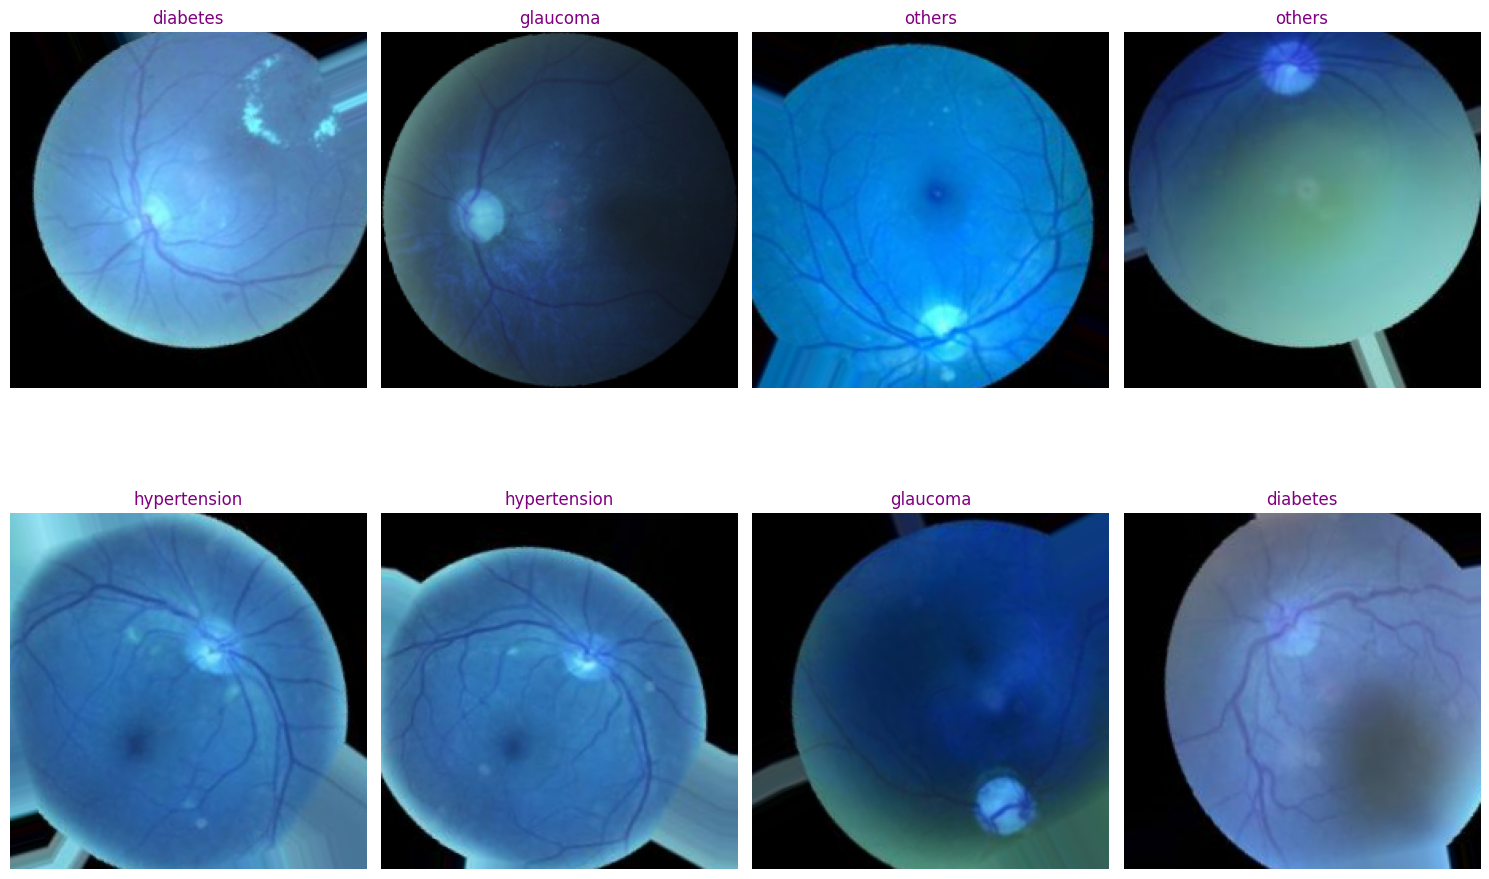

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

In [ ]:
# Define number of classes
num_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 3. VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

# Define base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
VGG16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
VGG16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Visualise the model

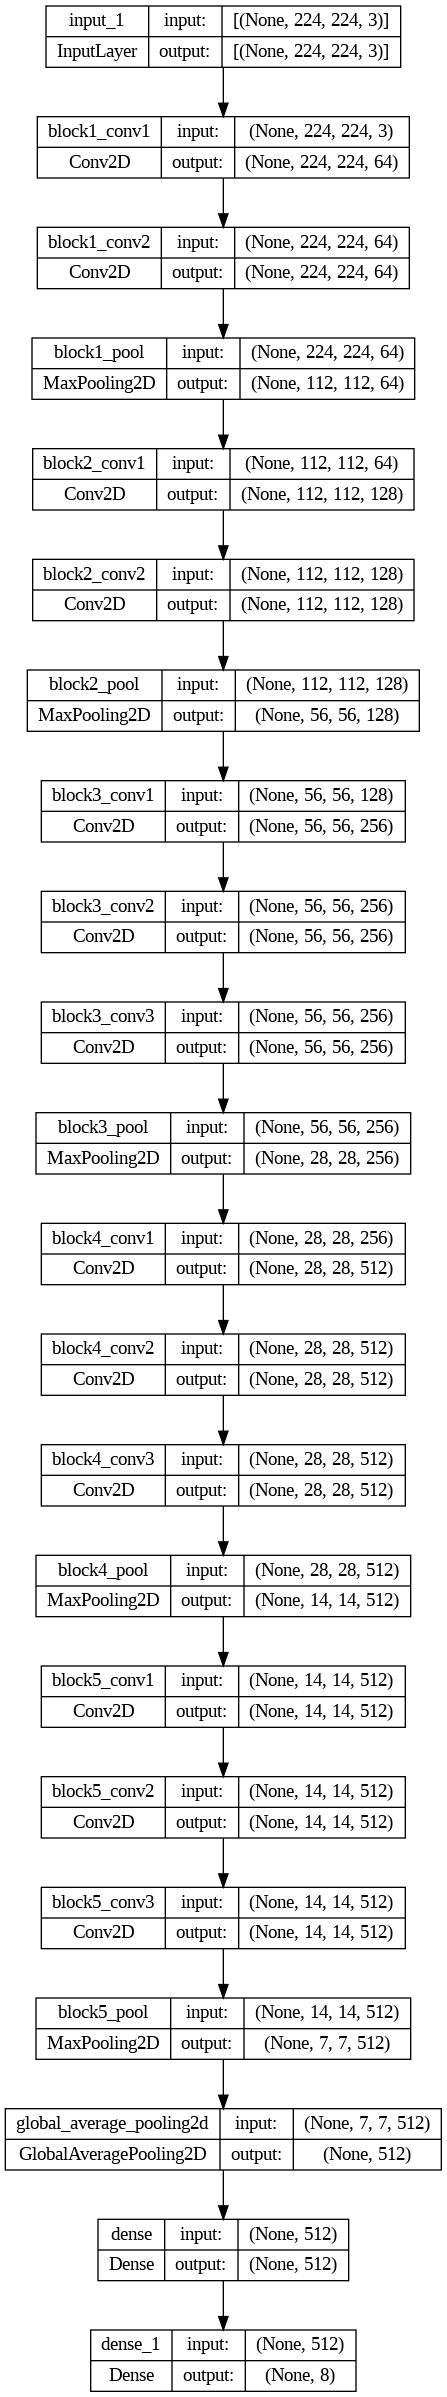

In [ ]:
# Plot and display architecture for VGG16 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(VGG16_model, to_file='VGG16_model.png', show_shapes=True, show_layer_names=True)
Image(filename='VGG16_model.png')

## Training the model

In [ ]:
np.random.seed(42)
# Train the model
history_VGG16 = VGG16_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
test_loss_vgg16, test_accuracy_vgg16 = VGG16_model.evaluate(Test)

Epoch 1/15
2415/2415 [==============================] - 14063s 6s/step - loss: 2.1318 - accuracy: 0.1339 - val_loss: 2.0781 - val_accuracy: 0.1364
Epoch 2/15
2415/2415 [==============================] - 797s 330ms/step - loss: 2.0788 - accuracy: 0.1308 - val_loss: 2.0782 - val_accuracy: 0.1359
Epoch 3/15
2415/2415 [==============================] - 808s 334ms/step - loss: 2.0786 - accuracy: 0.1334 - val_loss: 2.0779 - val_accuracy: 0.1362
Epoch 4/15
2415/2415 [==============================] - 819s 339ms/step - loss: 2.0786 - accuracy: 0.1298 - val_loss: 2.0781 - val_accuracy: 0.1365
Epoch 5/15
2415/2415 [==============================] - 813s 337ms/step - loss: 2.0786 - accuracy: 0.1294 - val_loss: 2.0783 - val_accuracy: 0.1364
Epoch 6/15
2415/2415 [==============================] - 806s 334ms/step - loss: 2.0786 - accuracy: 0.1311 - val_loss: 2.0783 - val_accuracy: 0.1287
Epoch 7/15
2415/2415 [==============================] - 798s 331ms/step - loss: 2.0785 - accuracy: 0.1310 - val_l

In [ ]:
tr_acc_VGG16 = history_VGG16.history['accuracy']
tr_loss_VGG16 = history_VGG16.history['loss']
v_acc_VGG16 = history_VGG16.history['val_accuracy']
v_loss_VGG16 = history_VGG16.history['val_loss']
index_acc_VGG16 = np.argmax(v_acc_VGG16)
high_Vacc_VGG16 = v_acc_VGG16[index_acc_VGG16]
index_loss_VGG16 = np.argmin(v_loss_VGG16)
low_Vloss_VGG16 = v_loss_VGG16[index_loss_VGG16]
Epochs_VGG16 = list(range(1, len(tr_acc_VGG16) + 1))
best_acc_VGG16 = f'Best epoch ={str(index_acc_VGG16 + 1)}'
best_loss_VGG16 = f'Best epoch ={str(index_loss_VGG16 + 1)}'

In [ ]:
VGG16_model.save(f"{BASE_PATH}VGG16_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}VGG16_model_history.npy", history_VGG16.history)

import pickle

with open(f"{BASE_PATH}history_VGG16.pickle", 'wb') as handle:
    pickle.dump(history_VGG16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)